In [1]:
import numpy as np
import pandas as pd
from datetime import date
from funciones import datos, analisis, modelado

### **Datos**
- Se traen los clientes con un cupo mayor a 200K para analizar su comportamiento (NPL)

In [27]:
base = datos.query_db(""" SELECT DISTINCT
                          c.documento
                          ,cr.id as credito_id
                          ,c.email
                          ,s.id as solicitud_id
     
                          ,DATE_FORMAT(cr.fechaConsignacion,'%Y-%m') as Periodo_Desembolso
     
                          ,case when cr.estadoCredito=1 then 'Pendiente Desembolso'
                          when cr.estadoCredito=2 then 'Desembolsado'
                          when cr.estadoCredito=3 then 'Pagado'
                          when cr.estadoCredito=4 then 'Vencido'
                          when cr.estadoCredito=5 then 'Mora'
                          when cr.estadoCredito=6 then 'Reportado'
                          when cr.estadoCredito=7 then 'Pagado Retrasado'
                          when cr.estadoCredito=8 then 'No Aceptado'
                          when cr.estadoCredito=9 then 'Pendiente Aceptacion'
                          when cr.estadoCredito=11 then 'Bloqueado'
                          when cr.estadoCredito=12 then 'Siniestrado'
                          when cr.estadoCredito=13 then 'Pagado Siniestrado'
                          when cr.estadoCredito=17 then 'Novado'
                          when cr.estadoCredito=18 then 'Pendiente Novacion' ELSE NULL END AS Estado_Credito

                          ,case when c.sexo=2 then 'Mujer' 
                          when c.sexo=1 then 'Hombre' else 'NA' end as Sexo_catg

                          ,case when c.estadocivil=1 then 'Soltero' 
                          when c.estadocivil=2 then 'Casado' 
                          when c.estadocivil=3 then 'Union Libre' 
                          when c.estadocivil=4 then 'Divorciado'
                          when c.estadocivil=5 then 'Viudo' end as estadocivil_catg
                          
                          ,case when cd.departamento IN ('BOGOTA','ATLANTICO','CUNDINAMARCA') then cd.departamento
                          when cd.departamento='ANTIOQUIA' and c.ciudad_id=1 then 'MEDELLIN'
                          when cd.departamento='ANTIOQUIA' and c.ciudad_id<>1 then 'ANTIOQUIA'
                          when cd.departamento='VALLE DEL CAUCA' then 'CALI' ELSE 'OTRO' END AS Ciudad_catg

                          ,c.numeropersonasdependientes
                          ,c.numeroHijos
     
                          ,case when TIMESTAMPDIFF(YEAR,c.fechaNacimiento,s.fechaSolicitud)>100 then 100 
                          else TIMESTAMPDIFF(YEAR,c.fechaNacimiento,s.fechaSolicitud) end as Edad_cal

                          ,cr.novaciones
                          ,cr.numeroCredito
                          ,cr.creditoOriginal
    
                          ,CAST(CASE WHEN REPLACE(SUBSTRING_INDEX(e.recomendacionDS,',',1),'Score: ','') REGEXP '^[0-9]' = 1
                          THEN REPLACE(SUBSTRING_INDEX(e.recomendacionDS,',',1),'Score: ','') ELSE NULL END AS SIGNED) AS Score_cal
                      
                          ,e.puntajeDS

                          ,s.plazoSolicitado

                          ,s.estadomovil

                          ,s.cantidadsolicitada

                          ,round(s.cantidadSolicitada/s.plazoSolicitado) as CantS_Dias

                          ,case when s.estadomovil=0 then 'Web'
                          when s.estadomovil=1 then 'App Movil'
                          when s.estadomovil=2 then 'Bot'
                          when s.estadomovil=3 then 'Admin'
                          when s.estadomovil=4 then 'Exp. Movil'
                          when s.estadomovil=5 then 'Exp. Movil'
                          when s.estadomovil=6 then 'Prestamo rapidos'
                          when s.estadomovil=7 then 'Tronex'
                          when s.estadomovil=8 then 'Refactor-Web'
                          when s.estadomovil=9 then 'Refactor-Responsive'
                          when s.estadomovil=10 then 'Novación_Web'
                          when s.estadomovil=11 then 'Novación_Movil' else 'Web' end as estadoMovil_catg

                          ,il.actividadLaboral

                          ,case when il.actividadLaboral=1 then 'Administrativas'
                          when il.actividadLaboral in (13,37) then 'Otro'
                          when il.actividadLaboral=3 then 'Operartivas y de servicio'
                          when il.actividadLaboral=4 then 'Ventas y Mercadeo'
                          when il.actividadLaboral=5 then 'Tecnicas' 
                          when il.actividadLaboral=26 then 'Microempresario' 
                          when il.actividadLaboral is null then NULL else 'Otros' end as actividadLaboral_catg

                          ,case when il.tipoTrabajador=1 then 'Empleado' 
                          when il.tipoTrabajador=2 then 'Independiente'
                          when il.tipoTrabajador=3 then 'Pensionado' 
                          when il.tipoTrabajador=4 then 'Desempleado' 
                          when il.tipoTrabajador is null then NULL else 'Otro' end as tipoTrabajador_catg

                          ,case when ire.tipoVivienda=1 then 'Rentada' 
                          when ire.tipoVivienda=2 then 'Propia'
                          when ire.tipoVivienda=3 then 'Familiar' 
                          when ire.tipoVivienda is null then NULL else 'Otro' end as tipoVivienda_catg
    
                          ,case when ia.nivelEstudio=1 then 'Ninguno' when ia.nivelEstudio=2 then 'Basico' 
                          when ia.nivelEstudio=3 then 'Bachiller' when ia.nivelEstudio=4 then 'Tecnico'
                          when ia.nivelEstudio=5 then 'Tecnologo' when ia.nivelEstudio=6 then 'Pregrado'
                          when ia.nivelEstudio=7 then 'Posgrado'
                          when ia.nivelEstudio is null then NULL else 'Otro' end as nivelEstudio_catg

                          ,case when iff.egresoMensual > 5000000 then 5000000
                          when iff.egresoMensual < 300000 then 300000
                          else iff.egresoMensual end as egresoMensual_iff_cal
                          
                          ,case when iff.ingresoMensual > 10000000 then 10000000
                          when iff.ingresoMensual < 450000 then 450000
                          else iff.ingresoMensual end as ingresoMensual_iff_cal
                          
                          ,case when YEAR(cr.fechaConsignacion)=2020 then round((case when iff.egresoMensual > 5000000 then 5000000
                          when iff.egresoMensual < 300000 then 300000 else iff.egresoMensual end)/877803,2)
                          when YEAR(cr.fechaConsignacion)=2021 then round((case when iff.egresoMensual > 5000000 then 5000000
                          when iff.egresoMensual < 300000 then 300000 else iff.egresoMensual end)/908526,2)
                          else null end as SMMLV_egreso_cal
                          
                          ,case when YEAR(cr.fechaConsignacion)=2020 
                          then round((case when iff.ingresoMensual > 10000000 then 10000000
                          when iff.ingresoMensual < 450000 then 450000 else iff.ingresoMensual end)/877803,2)
                          when YEAR(cr.fechaConsignacion)=2021 then round((case when iff.ingresoMensual > 10000000 then 10000000
                          when iff.ingresoMensual < 450000 then 450000 else iff.ingresoMensual end)/908526,2)
                          else null end as SMMLV_ingreso_cal
                      
                          ,round((case when iff.egresoMensual > 5000000 then 5000000
                           when iff.egresoMensual < 300000 then 300000 else iff.egresoMensual end) / 
                           (case when iff.ingresoMensual > 10000000 then 10000000
                           when iff.ingresoMensual < 450000 then 450000 else iff.ingresoMensual end),2) as Porcn_gasto_cal
                           
                          ,round(s.cantidadsolicitada/(case when iff.ingresoMensual > 10000000 then 10000000
                           when iff.ingresoMensual < 450000 then 450000 else iff.ingresoMensual end),2) as Rel_cants_ingreso_cal
                          
                          ,round(s.cantidadsolicitada/(case when iff.egresoMensual > 5000000 then 5000000
                           when iff.egresoMensual < 300000 then 300000 else iff.egresoMensual end),2) as Rel_cants_egreso_cal

                           ,TIMESTAMPDIFF(MONTH,pd.Primer_desembolso,cr.fechaConsignacion) AS Meses_Primer_Desembolso
                     
                           ,TIMESTAMPDIFF(MONTH,ps.Primera_Solicitud,s.fechaSolicitud) AS Meses_Primera_Solicitud
       
                           ,case when TIMESTAMPDIFF(MONTH,pr.Primer_Rechazo,s.fechaSolicitud) is null 
                           or TIMESTAMPDIFF(MONTH,pr.Primer_Rechazo,s.fechaSolicitud)<=0 then 0 
                           else TIMESTAMPDIFF(MONTH,pr.Primer_Rechazo,s.fechaSolicitud) end as Meses_Primer_Rechazo
     
                          ,d.valor

                          ,case when DATE_FORMAT(cr.fechaConsignacion,'%Y-%m-%d')=pd.Primer_desembolso 
                          OR pd.Primer_Credito=cr.creditoOriginal then 'Nuevo' ELSE 'Recurrente' END AS Tipo_Cliente

                          ,DATEDIFF(mp.max_fecha,DATE_ADD(cr.fechaConsignacion, INTERVAL s.plazoSolicitado DAY)) AS Dias_pago

                          FROM cliente c 
                          INNER JOIN solicitud s ON s.cliente_id = c.id 
                          INNER JOIN credito cr ON s.id = cr.solicitud_id
                          INNER JOIN estudiocredito e on s.id = e.solicitud_id
                          INNER JOIN desembolso d ON d.creditoId=cr.id
                          LEFT JOIN Ciudad cd ON cd.id=c.ciudad_id
                          LEFT JOIN infolaboral il on c.id=il.cliente_id
                          LEFT JOIN inforesidencia ire on c.id=ire.cliente_id
                          LEFT JOIN infofinanciera iff on c.id=iff.cliente_id
                          LEFT JOIN infoacademica ia on c.id=ia.cliente_id
                          ####### Primer Credito
                          LEFT JOIN (SELECT cl.documento
                          ,c.id AS Primer_Credito
                          ,DATE_FORMAT(MIN(c.fechaConsignacion),'%Y-%m-%d') AS Primer_Desembolso
                          FROM Cliente cl
                          INNER JOIN Solicitud s ON cl.id=s.cliente_id
                          INNER JOIN credito c ON s.id=c.solicitud_id
                          WHERE c.fechaConsignacion IS NOT NULL
                          GROUP BY cl.documento) pd ON pd.documento=c.documento
                          ########## Fecha Maxima de Pago por Documento
                          LEFT JOIN (SELECT c.id as credito_id
                          ,MAX(p.fecha) AS max_fecha 
                          FROM credito c
                          INNER JOIN pago p ON c.id = p.credito_id AND c.estadoCredito IN (3,7,13)
                          WHERE p.anulacion=1
                          GROUP BY c.id) mp on mp.credito_id=cr.id
                          ####### Primera Solicitud
                          LEFT JOIN (SELECT cl.documento
                          ,DATE_FORMAT(MIN(s.fechaSolicitud),'%Y-%m-%d') AS Primera_Solicitud
                          FROM Cliente cl
                          INNER JOIN Solicitud s ON cl.id=s.cliente_id
                          WHERE s.fechaSolicitud IS NOT NULL
                          GROUP BY cl.documento) ps ON ps.documento=c.documento
                          ####### Primer Rechazo
                          LEFT JOIN (SELECT cl.documento
                          ,DATE_FORMAT(MIN(s.fechaSolicitud),'%Y-%m-%d') AS Primer_Rechazo
                          FROM Cliente cl
                          INNER JOIN Solicitud s ON cl.id=s.cliente_id
                          WHERE s.estadoSolicitud=4 and s.fechaSolicitud IS NOT NULL
                          GROUP BY cl.documento) pr ON pr.documento=c.documento
                          
                          WHERE DATE_FORMAT(cr.fechaConsignacion,'%Y-%m') BETWEEN '2020-07' AND '2021-12' 
                          AND cr.producto_id=1 AND d.valor > 200000 """)

In [28]:
base.tail()

documento  credito_id                     email  solicitud_id  \
42511  1047449904     1381050   lastebaldi4@hotmail.com       3980477   
42512    79353529     1381078   aguila11926@hotmail.com       3980544   
42513  1014209562     1381017    Tatis-2301@hotmail.com       3980391   
42514    52424014     1381027    consultorath@gmail.com       3975416   
42515    79799142     1381045  csanchezporras@gmail.com       3980464   

      Periodo_Desembolso Estado_Credito Sexo_catg estadocivil_catg  \
42511            2021-12         Pagado     Mujer          Soltero   
42512            2021-12        Vencido    Hombre          Soltero   
42513            2021-12         Pagado     Mujer          Soltero   
42514            2021-12         Pagado     Mujer          Soltero   
42515            2021-12        Vencido    Hombre      Union Libre   

      Ciudad_catg  numeropersonasdependientes  ...  SMMLV_ingreso_cal  \
42511      BOGOTA                           0  ...               4.95   
42512      BOGOTA                           0  ...               2.73   
42513      BOGOTA                           0  ...               4.40   
42514    MEDELLIN                           0  ...               2.64   
42515      BOGOTA                           2  ...               9.91   

       Porcn_gasto_cal  Rel_cants_ingreso_cal  Rel_cants_egreso_cal  \
42511             0.33                   0.08                  0.23   
42512             0.32                   0.16                  0.50   
42513             0.25                   0.06                  0.25   
42514             0.58                   0.13                  0.21   
42515             0.17                   0.03                  0.17   

      Meses_Primer_Desembolso  Meses_Primera_Solicitud  Meses_Primer_Rechazo  \
42511                      28                       58                    58   
42512                      10                       50                    50   
42513                      24                       40                    40   
42514                      36                       36                     0   
42515                      37                       37                     0   

        valor  Tipo_Cliente  Dias_pago  
42511  350000    Recurrente      -10.0  
42512  400000    Recurrente        NaN  
42513  250000    Recurrente        0.0  
42514  300000    Recurrente        2.0  
42515  250000    Recurrente        NaN  

[5 rows x 40 columns]

In [8]:
base.query(" documento=='79353529' ").describe()

credito_id  numeropersonasdependientes  numeroHijos  Edad_cal  \
count  2.000000e+00                         2.0          2.0       2.0   
mean   1.232916e+06                         0.0          0.0      56.0   
std    2.095334e+05                         0.0          0.0       0.0   
min    1.084753e+06                         0.0          0.0      56.0   
25%    1.158834e+06                         0.0          0.0      56.0   
50%    1.232916e+06                         0.0          0.0      56.0   
75%    1.306997e+06                         0.0          0.0      56.0   
max    1.381078e+06                         0.0          0.0      56.0   

       novaciones  numeroCredito  Score_cal   puntajeDS  plazoSolicitado  \
count         2.0       2.000000        1.0    2.000000         2.000000   
mean          0.0       5.000000      653.0 -494.000000        26.000000   
std           0.0       1.414214        NaN  700.035713         5.656854   
min           0.0       4.000000      653.0 -989.000000        22.000000   
25%           0.0       4.500000      653.0 -741.500000        24.000000   
50%           0.0       5.000000      653.0 -494.000000        26.000000   
75%           0.0       5.500000      653.0 -246.500000        28.000000   
max           0.0       6.000000      653.0    1.000000        30.000000   

       estadomovil  ...  Rel_cants_egreso_cal  Meses_Primer_Desembolso  \
count          2.0  ...                   2.0                 2.000000   
mean           3.0  ...                   0.5                 7.500000   
std            0.0  ...                   0.0                 3.535534   
min            3.0  ...                   0.5                 5.000000   
25%            3.0  ...                   0.5                 6.250000   
50%            3.0  ...                   0.5                 7.500000   
75%            3.0  ...                   0.5                 8.750000   
max            3.0  ...                   0.5                10.000000   

       Meses_Primera_Solicitud  Meses_Primer_Rechazo     valor  Dias_pago  \
count                 2.000000              2.000000       2.0        0.0   
mean                 47.500000             47.500000  400000.0        NaN   
std                   3.535534              3.535534       0.0        NaN   
min                  45.000000             45.000000  400000.0        NaN   
25%                  46.250000             46.250000  400000.0        NaN   
50%                  47.500000             47.500000  400000.0        NaN   
75%                  48.750000             48.750000  400000.0        NaN   
max                  50.000000             50.000000  400000.0        NaN   

        ingresos  tipo_cotizante  ano_periodo_validado  mes_periodo_validado  
count        1.0             1.0                   1.0                   1.0  
mean   3549899.0             1.0                2021.0                  12.0  
std          NaN             NaN                   NaN                   NaN  
min    3549899.0             1.0                2021.0                  12.0  
25%    3549899.0             1.0                2021.0                  12.0  
50%    3549899.0             1.0                2021.0                  12.0  
75%    3549899.0             1.0                2021.0                  12.0  
max    3549899.0             1.0                2021.0                  12.0  

[8 rows x 29 columns]

In [26]:
#base.query(" documento=='1053586839' ")

In [32]:
base.shape

(42516, 40)

In [29]:
emails = tuple(set(base[base['email'].isnull()==False]['email'].tolist()))

In [30]:
df_emailge = datos.query_db(""" SELECT em.email
                                ,em.fraudRisk
                                ,CAST(em.EAScore AS SIGNED) as EAScore 
                                ,em.EAReason
                                ,em.EAReasonID
                                ,em.EAAdvice
                                ,em.EAAdviceID
                                ,em.EARiskBandID
                                ,em.ipISP AS IP_Servicio_Internet
                                ,em.ipuserType
                                ,case when em.ipregion='distrito capital' then 'BOGOTA'
                                when em.ipregion='antioquia' then 'ANTIOQUIA'
                                when em.ipregion='valle del cauca' then 'VALLE DEL CAUCA'
                                when em.ipregion='cundinamarca' then 'CUNDINAMARCA'
                                when em.ipregion in ('bolivar','atlantico') then 'ATLANTICO' ELSE 'OTRO' END AS Departamento_email
                                ,em.ipDistanceKm
                                ,CAST(REPLACE(LEFT(RIGHT(em.EAReason,16),5),' ','') AS DECIMAL (3,1)) as Antiguedad_Email
                                
                                FROM emailage_result em
                                INNER JOIN (SELECT email
                                ,MAX(id) AS Ult_id 
                                FROM emailage_result
                                where email in {emails}
                                GROUP BY email) ui ON ui.Ult_id=em.id """.format(emails=emails))

In [31]:
df_emailge.shape

(4442, 13)

In [33]:
solicitud_id = tuple(set(base['solicitud_id'].tolist()))

In [34]:
df_ip_data = datos.query_db(""" SELECT 
                                ip.loan_application_id as solicitud_id
                                
                                ,case when SUBSTRING_INDEX(ip.user_agent,')',1) like '%Windows%' then 'Windows'
                                when SUBSTRING_INDEX(ip.user_agent,')',1) like '%Android%' then 'Android'
                                when SUBSTRING_INDEX(ip.user_agent,')',1) like '%Macintosh%' then 'Apple'
                                when SUBSTRING_INDEX(ip.user_agent,')',1) like '%iPad%' then 'Apple'
                                when SUBSTRING_INDEX(ip.user_agent,')',1) like '%iPhone%' then 'Apple'
                                when SUBSTRING_INDEX(ip.user_agent,')',1) like '%X11%' then 'Linux' else 'Otro' end AS Sistema_Operativo
                                
                                ,case when ip.region='Bogota D.C.' then 'BOGOTA'
                                when ip.region='Antioquia' then 'ANTIOQUIA'
                                when ip.region='Departamento del Valle del Cauca' then 'VALLE DEL CAUCA'
                                when ip.region='Cundinamarca' then 'CUNDINAMARCA'
                                when ip.region in ('Departamento de Bolivar','Atlántico') then 'ATLANTICO' ELSE 'OTRO' END AS Departamento_IP

                                FROM ip_data_response ip
                                INNER JOIN (SELECT loan_application_id
                                ,MAX(id) AS ult_id
                                FROM ip_data_response 
                                WHERE loan_application_id in {solicitud_id}
                                GROUP BY loan_application_id) uip ON uip.ult_id=ip.id
                                 """.format(solicitud_id=solicitud_id))
                                 

In [35]:
df_ip_data.shape

(42217, 3)

### **Actualización Estado de Credito de las Novaciones**

In [38]:
novados = sqldf(""" select case when creditoOriginal is null then cast(credito_id as int) 
                    else cast(creditoOriginal as int) end as credito_id
                    from base where Estado_Credito='Novado' """)

In [39]:
novados.shape

(12475, 1)

In [40]:
codigo = tuple(set(novados['credito_id'].tolist()))

In [41]:
creditos = base.query(" Estado_Credito in ('Mora','Pagado','Pagado Retrasado','Reportado','Siniestrado') ")

In [42]:
novaciones = datos.query_db(""" SELECT DISTINCT
                                c.documento
                                ,cr.id as credito_id
                                ,c.email
                                ,s.id as solicitud_id
           
                                ,DATE_FORMAT(cr.fechaConsignacion,'%Y-%m') as Periodo_Desembolso
           
                                ,case when cr.estadoCredito=1 then 'Pendiente Desembolso'
                                when cr.estadoCredito=2 then 'Desembolsado'
                                when cr.estadoCredito=3 then 'Pagado'
                                when cr.estadoCredito=4 then 'Vencido'
                                when cr.estadoCredito=5 then 'Mora'
                                when cr.estadoCredito=6 then 'Reportado'
                                when cr.estadoCredito=7 then 'Pagado Retrasado'
                                when cr.estadoCredito=8 then 'No Aceptado'
                                when cr.estadoCredito=9 then 'Pendiente Aceptacion'
                                when cr.estadoCredito=11 then 'Bloqueado'
                                when cr.estadoCredito=12 then 'Siniestrado'
                                when cr.estadoCredito=13 then 'Pagado Siniestrado'
                                when cr.estadoCredito=17 then 'Novado'
                                when cr.estadoCredito=18 then 'Pendiente Novacion' ELSE NULL END AS Estado_Credito
      
                                ,case when c.sexo=2 then 'Mujer' 
                                when c.sexo=1 then 'Hombre' else 'NA' end as Sexo_catg

                                ,case when c.estadocivil=1 then 'Soltero' 
                                when c.estadocivil=2 then 'Casado' 
                                when c.estadocivil=3 then 'Union Libre' 
                                when c.estadocivil=4 then 'Divorciado'
                                when c.estadocivil=5 then 'Viudo' end as estadocivil_catg
                                
                                ,case when cd.departamento IN ('BOGOTA','ATLANTICO','CUNDINAMARCA') then cd.departamento
                                when cd.departamento='ANTIOQUIA' and c.ciudad_id=1 then 'MEDELLIN'
                                when cd.departamento='ANTIOQUIA' and c.ciudad_id<>1 then 'ANTIOQUIA'
                                when cd.departamento='VALLE DEL CAUCA' then 'CALI' ELSE 'OTRO' END AS Ciudad_catg
      
                                ,c.numeropersonasdependientes
                                ,c.numeroHijos
           
                                ,case when TIMESTAMPDIFF(YEAR,c.fechaNacimiento,s.fechaSolicitud)>100 then 100 
                                else TIMESTAMPDIFF(YEAR,c.fechaNacimiento,s.fechaSolicitud) end as Edad_cal
      
                                ,cr.novaciones
                                ,cr.numeroCredito
                                ,cr.creditoOriginal
          
                                ,CAST(CASE WHEN REPLACE(SUBSTRING_INDEX(e.recomendacionDS,',',1),'Score: ','') REGEXP '^[0-9]' = 1
                                THEN REPLACE(SUBSTRING_INDEX(e.recomendacionDS,',',1),'Score: ','') ELSE NULL END AS SIGNED) AS Score_cal
                            
                                ,e.puntajeDS
      
                                ,s.plazoSolicitado
      
                                ,s.estadomovil
      
                                ,s.cantidadsolicitada
      
                                ,round(s.cantidadSolicitada/s.plazoSolicitado) as CantS_Dias
      
                                ,case when s.estadomovil=0 then 'Web'
                                when s.estadomovil=1 then 'App Movil'
                                when s.estadomovil=2 then 'Bot'
                                when s.estadomovil=3 then 'Admin'
                                when s.estadomovil=4 then 'Exp. Movil'
                                when s.estadomovil=5 then 'Exp. Movil'
                                when s.estadomovil=6 then 'Prestamo rapidos'
                                when s.estadomovil=7 then 'Tronex'
                                when s.estadomovil=8 then 'Refactor-Web'
                                when s.estadomovil=9 then 'Refactor-Responsive'
                                when s.estadomovil=10 then 'Novación_Web'
                                when s.estadomovil=11 then 'Novación_Movil' else 'Web' end as estadoMovil_catg
      
                                ,il.actividadLaboral
      
                                ,case when il.actividadLaboral=1 then 'Administrativas'
                                when il.actividadLaboral in (13,37) then 'Otro'
                                when il.actividadLaboral=3 then 'Operartivas y de servicio'
                                when il.actividadLaboral=4 then 'Ventas y Mercadeo'
                                when il.actividadLaboral=5 then 'Tecnicas' 
                                when il.actividadLaboral=26 then 'Microempresario' 
                                when il.actividadLaboral is null then NULL else 'Otros' end as actividadLaboral_catg
      
                                ,case when il.tipoTrabajador=1 then 'Empleado' when il.tipoTrabajador=2 then 'Independiente'
                                when il.tipoTrabajador=3 then 'Pensionado' 
                                when il.tipoTrabajador=4 then 'Desempleado' 
                                when il.tipoTrabajador is null then NULL else 'Otro' end as tipoTrabajador_catg

                                ,case when ire.tipoVivienda=1 then 'Rentada' 
                                when ire.tipoVivienda=2 then 'Propia'
                                when ire.tipoVivienda=3 then 'Familiar' 
                                when ire.tipoVivienda is null then NULL else 'Otro' end as tipoVivienda_catg
          
                                ,case when ia.nivelEstudio=1 then 'Ninguno' when ia.nivelEstudio=2 then 'Basico' 
                                when ia.nivelEstudio=3 then 'Bachiller' when ia.nivelEstudio=4 then 'Tecnico'
                                when ia.nivelEstudio=5 then 'Tecnologo' when ia.nivelEstudio=6 then 'Pregrado'
                                when ia.nivelEstudio=7 then 'Posgrado'
                                when ia.nivelEstudio is null then NULL else 'Otro' end as nivelEstudio_catg
      
                                ,case when iff.egresoMensual > 5000000 then 5000000
                                when iff.egresoMensual < 300000 then 300000
                                else iff.egresoMensual end as egresoMensual_iff_cal
                                
                                ,case when iff.ingresoMensual > 10000000 then 10000000
                                when iff.ingresoMensual < 450000 then 450000
                                else iff.ingresoMensual end as ingresoMensual_iff_cal
                                
                                ,case when YEAR(cr.fechaConsignacion)=2020 then round((case when iff.egresoMensual > 5000000 then 5000000
                                when iff.egresoMensual < 300000 then 300000 else iff.egresoMensual end)/877803,2)
                                when YEAR(cr.fechaConsignacion)=2021 then round((case when iff.egresoMensual > 5000000 then 5000000
                                when iff.egresoMensual < 300000 then 300000 else iff.egresoMensual end)/908526,2)
                                else null end as SMMLV_egreso_cal
                                
                                ,case when YEAR(cr.fechaConsignacion)=2020 
                                then round((case when iff.ingresoMensual > 10000000 then 10000000
                                when iff.ingresoMensual < 450000 then 450000 else iff.ingresoMensual end)/877803,2)
                                when YEAR(cr.fechaConsignacion)=2021 then round((case when iff.ingresoMensual > 10000000 then 10000000
                                when iff.ingresoMensual < 450000 then 450000 else iff.ingresoMensual end)/908526,2)
                                else null end as SMMLV_ingreso_cal
                            
                                ,round((case when iff.egresoMensual > 5000000 then 5000000
                                 when iff.egresoMensual < 300000 then 300000 else iff.egresoMensual end) / 
                                 (case when iff.ingresoMensual > 10000000 then 10000000
                                 when iff.ingresoMensual < 450000 then 450000 else iff.ingresoMensual end),2) as Porcn_gasto_cal
                                 
                                ,round(s.cantidadsolicitada/(case when iff.ingresoMensual > 10000000 then 10000000
                                 when iff.ingresoMensual < 450000 then 450000 else iff.ingresoMensual end),2) as Rel_cants_ingreso_cal
                                
                                ,round(s.cantidadsolicitada/(case when iff.egresoMensual > 5000000 then 5000000
                                when iff.egresoMensual < 300000 then 300000 else iff.egresoMensual end),2) as Rel_cants_egreso_cal
     
                                ,TIMESTAMPDIFF(MONTH,pd.Primer_desembolso,cr.fechaConsignacion) AS Meses_Primer_Desembolso
                          
                                ,TIMESTAMPDIFF(MONTH,ps.Primera_Solicitud,s.fechaSolicitud) AS Meses_Primera_Solicitud
            
                                ,case when TIMESTAMPDIFF(MONTH,pr.Primer_Rechazo,s.fechaSolicitud) is null 
                                or TIMESTAMPDIFF(MONTH,pr.Primer_Rechazo,s.fechaSolicitud)<=0 then 0 
                                else TIMESTAMPDIFF(MONTH,pr.Primer_Rechazo,s.fechaSolicitud) end as Meses_Primer_Rechazo
          
                                ,d.valor
      
                                ,case when DATE_FORMAT(cr.fechaConsignacion,'%Y-%m-%d')=pd.Primer_desembolso 
                                OR pd.Primer_Credito=cr.creditoOriginal then 'Nuevo' ELSE 'Recurrente' END AS Tipo_Cliente
      
                                ,DATEDIFF(mp.max_fecha,DATE_ADD(cr.fechaConsignacion, INTERVAL s.plazoSolicitado DAY)) AS Dias_pago
          
                                FROM cliente c 
                                INNER JOIN solicitud s ON s.cliente_id = c.id 
                                INNER JOIN (SELECT c.* 
                                            FROM credito c
                                            INNER JOIN (SELECT c.documento,e.fechaEvaluacionDS,MAX(ce.id) as credito_id
                                                        FROM cliente c
                                                        INNER JOIN solicitud s ON c.id=s.cliente_id
                                                        INNER JOIN credito ce ON s.id=ce.solicitud_id
                                                        INNER JOIN estudiocredito e on s.id = e.solicitud_id
                                                        WHERE ce.creditoOriginal in {codigo} or ce.id in {codigo}
                                                        GROUP BY c.documento,e.fechaEvaluacionDS) mi ON mi.credito_id=c.id) 
                                                        cr ON s.id=cr.solicitud_id
                                INNER JOIN estudiocredito e on s.id = e.solicitud_id
                                LEFT JOIN desembolso d ON d.creditoId=cr.id
                                LEFT JOIN Ciudad cd ON cd.id=c.ciudad_id
                                LEFT JOIN infolaboral il on c.id=il.cliente_id
                                LEFT JOIN inforesidencia ire on c.id=ire.cliente_id
                                LEFT JOIN infofinanciera iff on c.id=iff.cliente_id
                                LEFT JOIN infoacademica ia on c.id=ia.cliente_id
                                ####### Primer Credito
                                LEFT JOIN (SELECT cl.documento
                                ,c.id AS Primer_Credito
                                ,DATE_FORMAT(MIN(c.fechaConsignacion),'%Y-%m-%d') AS Primer_Desembolso
                                FROM Cliente cl
                                INNER JOIN Solicitud s ON cl.id=s.cliente_id
                                INNER JOIN credito c ON s.id=c.solicitud_id
                                WHERE c.fechaConsignacion IS NOT NULL
                                GROUP BY cl.documento) pd ON pd.documento=c.documento
                                ########## Fecha Maxima de Pago por Documento
                                LEFT JOIN (SELECT c.id as credito_id
                                ,MAX(p.fecha) AS max_fecha 
                                FROM credito c
                                INNER JOIN pago p ON c.id = p.credito_id AND c.estadoCredito IN (3,7,13)
                                WHERE p.anulacion=1
                                GROUP BY c.id) mp on mp.credito_id=cr.id
                                ####### Primera Solicitud
                                LEFT JOIN (SELECT cl.documento
                                ,DATE_FORMAT(MIN(s.fechaSolicitud),'%Y-%m-%d') AS Primera_Solicitud
                                FROM Cliente cl
                                INNER JOIN Solicitud s ON cl.id=s.cliente_id
                                WHERE s.fechaSolicitud IS NOT NULL
                                GROUP BY cl.documento) ps ON ps.documento=c.documento
                                ####### Primer Rechazo
                                LEFT JOIN (SELECT cl.documento
                                ,DATE_FORMAT(MIN(s.fechaSolicitud),'%Y-%m-%d') AS Primer_Rechazo
                                FROM Cliente cl
                                INNER JOIN Solicitud s ON cl.id=s.cliente_id
                                WHERE s.estadoSolicitud=4 and s.fechaSolicitud IS NOT NULL
                                GROUP BY cl.documento) pr ON pr.documento=c.documento """.format(codigo=codigo))

In [43]:
novaciones.shape

(11920, 40)

In [44]:
novaciones.groupby('Estado_Credito').count()[['credito_id']]

credito_id
Estado_Credito                
Bloqueado                    4
Desembolsado              1750
Mora                       208
Novado                      28
Pagado                    6995
Pagado Retrasado          1981
Pagado Siniestrado           3
Pendiente Novacion          16
Reportado                  679
Siniestrado                  3
Vencido                    253

In [45]:
novaciones = novaciones.query(" Estado_Credito in ('Mora','Pagado','Pagado Retrasado','Reportado','Siniestrado') ")

In [46]:
df_union = pd.concat([creditos, novaciones])

In [47]:
df_union.head()

documento  credito_id                   email  solicitud_id  \
2    80735163      668332  barjeisson@hotmail.com       1974599   
4    35144907      668346  mivale1624@hotmail.com       1974638   
6  1030672573      668367   juanslizcano@yahoo.es       1974742   
7    80020923      668380      jcogalan@gmail.com       1974776   
8    52515400      668385  palimon_22@hotmail.com       1974782   

  Periodo_Desembolso Estado_Credito Sexo_catg estadocivil_catg Ciudad_catg  \
2            2020-07         Pagado    Hombre          Soltero      BOGOTA   
4            2020-07         Pagado     Mujer      Union Libre      BOGOTA   
6            2020-07         Pagado    Hombre          Soltero      BOGOTA   
7            2020-07         Pagado    Hombre           Casado      BOGOTA   
8            2020-07         Pagado     Mujer           Casado      BOGOTA   

   numeropersonasdependientes  ...  SMMLV_ingreso_cal  Porcn_gasto_cal  \
2                           2  ...               3.99             0.57   
4                           1  ...               1.82             0.31   
6                           0  ...               3.19             0.22   
7                           1  ...               5.91             0.77   
8                           0  ...               2.85             0.40   

   Rel_cants_ingreso_cal  Rel_cants_egreso_cal Meses_Primer_Desembolso  \
2                   0.07                  0.13                      19   
4                   0.19                  0.60                      10   
6                   0.09                  0.40                       7   
7                   0.05                  0.06                      11   
8                   0.11                  0.28                       4   

   Meses_Primera_Solicitud  Meses_Primer_Rechazo     valor  Tipo_Cliente  \
2                       19                     0  250000.0    Recurrente   
4                       12                    12  300000.0    Recurrente   
6                       20                    20  250000.0    Recurrente   
7                       17                    17  250000.0    Recurrente   
8                       18                     0  280000.0    Recurrente   

   Dias_pago  
2      -15.0  
4        0.0  
6        9.0  
7       -2.0  
8       -2.0  

[5 rows x 40 columns]

In [48]:
df_union.shape

(39717, 40)

In [49]:
df_union[df_union['credito_id'].duplicated()==True]

Empty DataFrame
Columns: [documento, credito_id, email, solicitud_id, Periodo_Desembolso, Estado_Credito, Sexo_catg, estadocivil_catg, Ciudad_catg, numeropersonasdependientes, numeroHijos, Edad_cal, novaciones, numeroCredito, creditoOriginal, Score_cal, puntajeDS, plazoSolicitado, estadomovil, cantidadsolicitada, CantS_Dias, estadoMovil_catg, actividadLaboral, actividadLaboral_catg, tipoTrabajador_catg, tipoVivienda_catg, nivelEstudio_catg, egresoMensual_iff_cal, ingresoMensual_iff_cal, SMMLV_egreso_cal, SMMLV_ingreso_cal, Porcn_gasto_cal, Rel_cants_ingreso_cal, Rel_cants_egreso_cal, Meses_Primer_Desembolso, Meses_Primera_Solicitud, Meses_Primer_Rechazo, valor, Tipo_Cliente, Dias_pago]
Index: []

[0 rows x 40 columns]

### **Calculo del Target, por Comportamiento Crediticio**

In [50]:
df_union.groupby('Tipo_Cliente').count()[['credito_id']] / df_union.shape[0] * 100

credito_id
Tipo_Cliente            
Nuevo           0.488456
Recurrente     99.511544

In [51]:
df_union.groupby('Tipo_Cliente').count()[['credito_id']]

credito_id
Tipo_Cliente            
Nuevo                194
Recurrente         39523

In [54]:
df_ip_data.dtypes

solicitud_id          int64
Sistema_Operativo    object
Departamento_IP      object
dtype: object

In [56]:
df_union_all = df_union.merge(df_ip_data, how='left', on='solicitud_id')

In [59]:
df_union.shape

(39717, 40)

In [58]:
df_union_all.shape

(39717, 42)

In [60]:
df_union_all = sqldf(""" select *
                         ,case when Estado_Credito in ('Reportado','Mora','Siniestrado','Pagado Siniestrado')
                         or Estado_Credito='Pagado Retrasado' and Dias_pago>=130 then 1 else 0 end as Target
                         from df_union_all """)

In [61]:
df_union_all.head()

documento  credito_id                   email  solicitud_id  \
0    80735163      668332  barjeisson@hotmail.com       1974599   
1    35144907      668346  mivale1624@hotmail.com       1974638   
2  1030672573      668367   juanslizcano@yahoo.es       1974742   
3    80020923      668380      jcogalan@gmail.com       1974776   
4    52515400      668385  palimon_22@hotmail.com       1974782   

  Periodo_Desembolso Estado_Credito Sexo_catg estadocivil_catg Ciudad_catg  \
0            2020-07         Pagado    Hombre          Soltero      BOGOTA   
1            2020-07         Pagado     Mujer      Union Libre      BOGOTA   
2            2020-07         Pagado    Hombre          Soltero      BOGOTA   
3            2020-07         Pagado    Hombre           Casado      BOGOTA   
4            2020-07         Pagado     Mujer           Casado      BOGOTA   

   numeropersonasdependientes  ...  Rel_cants_egreso_cal  \
0                           2  ...                  0.13   
1                           1  ...                  0.60   
2                           0  ...                  0.40   
3                           1  ...                  0.06   
4                           0  ...                  0.28   

   Meses_Primer_Desembolso  Meses_Primera_Solicitud  Meses_Primer_Rechazo  \
0                       19                       19                     0   
1                       10                       12                    12   
2                        7                       20                    20   
3                       11                       17                    17   
4                        4                       18                     0   

      valor  Tipo_Cliente  Dias_pago  Sistema_Operativo  Departamento_IP  \
0  250000.0    Recurrente      -15.0            Android           BOGOTA   
1  300000.0    Recurrente        0.0            Android        ANTIOQUIA   
2  250000.0    Recurrente        9.0            Windows           BOGOTA   
3  250000.0    Recurrente       -2.0            Windows           BOGOTA   
4  280000.0    Recurrente       -2.0            Windows           BOGOTA   

   Target  
0       0  
1       0  
2       0  
3       0  
4       0  

[5 rows x 43 columns]

In [62]:
df_union_all.groupby('Target').count()[['credito_id']] / df_union_all.shape[0] * 100

credito_id
Target            
0        92.242617
1         7.757383

In [63]:
df_union_all.groupby('Target').count()[['credito_id']]

credito_id
Target            
0            36636
1             3081

In [64]:
df_union_all.groupby('Estado_Credito', as_index=False).agg(Total=('credito_id','count'), Malos=('Target','sum'))

Estado_Credito  Total  Malos
0              Mora    576    576
1            Pagado  32487      0
2  Pagado Retrasado   4737    588
3         Reportado   1908   1908
4       Siniestrado      9      9

In [78]:
2471/(2471+27364)

0.08282218870454165

In [ ]:
2471 - 15
x - 85

In [79]:
(2471*0.85)/0.15

14002.333333333334

In [82]:
2471/(2471+14002)

0.1500030352698355

In [84]:
df_buenos = df_union.query(" Estado_Credito=='Pagado' ").sample(n=14002)

In [85]:
df_buenos.shape

(14002, 39)

In [104]:
df_muestra = pd.concat([df_buenos, df_union.query(" Target==1 ")])

In [102]:
df_muestra.groupby('Target').count()[['credito_id']] / df_muestra.shape[0] * 100

credito_id
Target            
0        84.999696
1        15.000304

In [105]:
df_muestra.shape

(16473, 39)

In [65]:
print(df_union_all.columns.to_list())

['documento', 'credito_id', 'email', 'solicitud_id', 'Periodo_Desembolso', 'Estado_Credito', 'Sexo_catg', 'estadocivil_catg', 'Ciudad_catg', 'numeropersonasdependientes', 'numeroHijos', 'Edad_cal', 'novaciones', 'numeroCredito', 'creditoOriginal', 'Score_cal', 'puntajeDS', 'plazoSolicitado', 'estadomovil', 'cantidadsolicitada', 'CantS_Dias', 'estadoMovil_catg', 'actividadLaboral', 'actividadLaboral_catg', 'tipoTrabajador_catg', 'tipoVivienda_catg', 'nivelEstudio_catg', 'egresoMensual_iff_cal', 'ingresoMensual_iff_cal', 'SMMLV_egreso_cal', 'SMMLV_ingreso_cal', 'Porcn_gasto_cal', 'Rel_cants_ingreso_cal', 'Rel_cants_egreso_cal', 'Meses_Primer_Desembolso', 'Meses_Primera_Solicitud', 'Meses_Primer_Rechazo', 'valor', 'Tipo_Cliente', 'Dias_pago', 'Sistema_Operativo', 'Departamento_IP', 'Target']


In [66]:
no_campos_bi = ['documento','credito_id','email','solicitud_id','Periodo_Desembolso','Estado_Credito','creditoOriginal','Dias_pago','novaciones','valor','Target']

In [68]:
campos_bi = list(set(df_union_all.columns.to_list()) - set(no_campos_bi))

In [69]:
len(campos_bi)

32

### **Analisis de la Variables**

In [70]:
df_univariado = analisis.univariado(campos_bi, df_union_all, 40)

In [71]:
datos.guardar('no', 'Informes', 'Univariado_ALL', df_univariado)

In [72]:
catg = ['actividadLaboral_catg','tipoVivienda_catg','estadocivil_catg','Sexo_catg','nivelEstudio_catg','Tipo_Cliente'
       ,'tipoTrabajador_catg','Ciudad_catg','estadoMovil_catg', 'Sistema_Operativo', 'Departamento_IP']

In [73]:
num = list(set(campos_bi) - set(catg))

In [75]:
df_union_all[catg] = df_union_all[catg].fillna('Vacio')

In [76]:
df_union_all[num] = df_union_all[num].fillna(-1)

In [77]:
df_bivariado = analisis.bivariado(df_union_all, campos_bi, 'Target')

In [71]:
#df_agg = df_union.groupby('Periodo_Desembolso', as_index=False).agg(Total=('credito_id','count'), Malos=('Target','sum'))

In [72]:
#datos.guardar('no', 'Informes', 'Tasa_Malos', df_agg)

In [78]:
df_bivariado.groupby('Variable', as_index=False).agg(IV=('Total IV','max')).sort_values(by='IV', ascending=False).head(20)

Variable        IV
23   ingresoMensual_iff_cal  0.382794
11        SMMLV_ingreso_cal  0.372122
9     Rel_cants_ingreso_cal  0.324431
25            numeroCredito  0.297484
8      Rel_cants_egreso_cal  0.248942
10         SMMLV_egreso_cal  0.245125
12                Score_cal  0.242823
24        nivelEstudio_catg  0.236225
4   Meses_Primer_Desembolso  0.218172
19    egresoMensual_iff_cal  0.206881
28          plazoSolicitado  0.198691
14        Sistema_Operativo  0.198514
22              estadomovil  0.197454
20         estadoMovil_catg  0.197251
2           Departamento_IP  0.165451
0                CantS_Dias  0.155365
16         actividadLaboral  0.130100
6   Meses_Primera_Solicitud  0.117729
18       cantidadsolicitada  0.100680
5      Meses_Primer_Rechazo  0.096470

In [80]:
df_bivariado.query(" Variable=='nivelEstudio_catg' ").sort_values(by='Bad Rate', ascending=False)

Variable      Value    All   Good  Bad     Share  Bad Rate  \
1430  nivelEstudio_catg     Basico    216    183   33  0.005438  0.152778   
1429  nivelEstudio_catg  Bachiller   4446   3792  654  0.111942  0.147099   
1428  nivelEstudio_catg    Tecnico   5893   5223  670  0.148375  0.113694   
1427  nivelEstudio_catg  Tecnologo   5575   5089  486  0.140368  0.087175   
1426  nivelEstudio_catg    Ninguno     28     26    2  0.000705  0.071429   
1425  nivelEstudio_catg   Pregrado  14188  13303  885  0.357227  0.062377   
1424  nivelEstudio_catg   Posgrado   9371   9020  351  0.235944  0.037456   

      Distribution Good  Distribution Bad       WoE        IV  Total IV  
1430           0.004995          0.010711 -0.762799  0.004360  0.236225  
1429           0.103505          0.212269 -0.718236  0.078118  0.236225  
1428           0.142565          0.217462 -0.422228  0.031624  0.236225  
1427           0.138907          0.157741 -0.127149  0.002395  0.236225  
1426           0.000710          0.000649  0.089172  0.000005  0.236225  
1425           0.363113          0.287244  0.234380  0.017782  0.236225  
1424           0.246206          0.113924  0.770636  0.101941  0.236225

In [117]:
analisis.correlacion(df_muestra[num]).head(20)

FirstVariable           SecondVariable  Correlation
0          SMMLV_egreso_cal    egresoMensual_iff_cal       0.9996
1         SMMLV_ingreso_cal   ingresoMensual_iff_cal       0.9994
2             numeroCredito  Meses_Primer_Desembolso       0.8078
3           plazoSolicitado               CantS_Dias       0.7139
4      Meses_Primer_Rechazo  Meses_Primera_Solicitud       0.6827
5   Meses_Primera_Solicitud  Meses_Primer_Desembolso       0.6761
6         SMMLV_ingreso_cal         SMMLV_egreso_cal       0.6493
7          SMMLV_egreso_cal   ingresoMensual_iff_cal       0.6485
8         SMMLV_ingreso_cal    egresoMensual_iff_cal       0.6483
9     egresoMensual_iff_cal   ingresoMensual_iff_cal       0.6482
10        SMMLV_ingreso_cal    Rel_cants_ingreso_cal       0.6343
11    Rel_cants_ingreso_cal   ingresoMensual_iff_cal       0.6318
12         SMMLV_egreso_cal     Rel_cants_egreso_cal       0.6265
13     Rel_cants_egreso_cal    egresoMensual_iff_cal       0.6257
14    Rel_cants_ingreso_cal     Rel_cants_egreso_cal       0.6152
15    egresoMensual_iff_cal          Porcn_gasto_cal       0.5835
16         SMMLV_egreso_cal          Porcn_gasto_cal       0.5824
17  Meses_Primera_Solicitud            numeroCredito       0.5647
18       cantidadsolicitada               CantS_Dias       0.5225
19    Rel_cants_ingreso_cal       cantidadsolicitada       0.5178

In [118]:
datos.guardar('no', 'DB', 'Base_Muestra', df_muestra)

In [119]:
datos.guardar('no', 'DB', 'Base_Union', df_union)

### **Visualización y Correlación de las Variables**

In [2]:
base_muestra = pd.read_csv(r'C:\Users\Jhon.Fonseca\Documents\Proyectos\Aumento_Cupo\DB\Base_Muestra.csv', sep='|', decimal=',')

In [3]:
import sweetviz as sv
from featurewiz import featurewiz

Imported featurewiz: advanced feature engg and selection library. Version=0.0.42
output = featurewiz(dataname, target, corr_limit=0.70,
                    verbose=2, sep=',', header=0, test_data='',
                    feature_engg='', category_encoders='')
Create new features via 'feature_engg' flag : ['interactions','groupby','target']
                                


In [3]:
campos = ['actividadLaboral_catg', 'tipoVivienda_catg', 'estadocivil_catg', 'Meses_Primer_Rechazo', 'Sexo_catg', 'SMMLV_ingreso_cal', 'estadomovil'
         , 'Rel_cants_ingreso_cal', 'SMMLV_egreso_cal', 'Rel_cants_egreso_cal', 'plazoSolicitado', 'puntajeDS', 'nivelEstudio_catg'
         , 'tipoTrabajador_catg', 'Ciudad_catg', 'Score_cal', 'numeroHijos', 'estadoMovil_catg', 'Meses_Primera_Solicitud', 'numeroCredito'
         , 'Meses_Primer_Desembolso', 'Porcn_gasto_cal', 'cantidadsolicitada', 'actividadLaboral', 'CantS_Dias', 'numeropersonasdependientes'
         , 'Edad_cal','Target']

In [13]:
advert_report = sv.analyze(base_muestra[campos], target_feat='Target')
advert_report.show_html('Visualizacion_Base_Muestra.html')

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:02 -> (00:00 left)


Report Visualizacion_Base_Muestra.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
Loading train data...
Shape of your Data Set loaded: (16473, 28)
Loading test data...
    Filename is an empty string or file not able to be loaded
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    27 Predictors classified...
        No variables removed since no ID or low-information variables found in data set
No GPU active on this device
    Running XGBoost using CPU parameters
Removing 0 columns from further processing since ID or low information variables
    columns removed: []
    After removing redundant variables from further processing, features left = 27
#### Single_Label Binary_Classification Feature Selection Started ####
Searching for highly correlated variables from 19 variables using SULOV method
#####  SULOV : Searching for Uncorrelated List Of Variables (takes time..

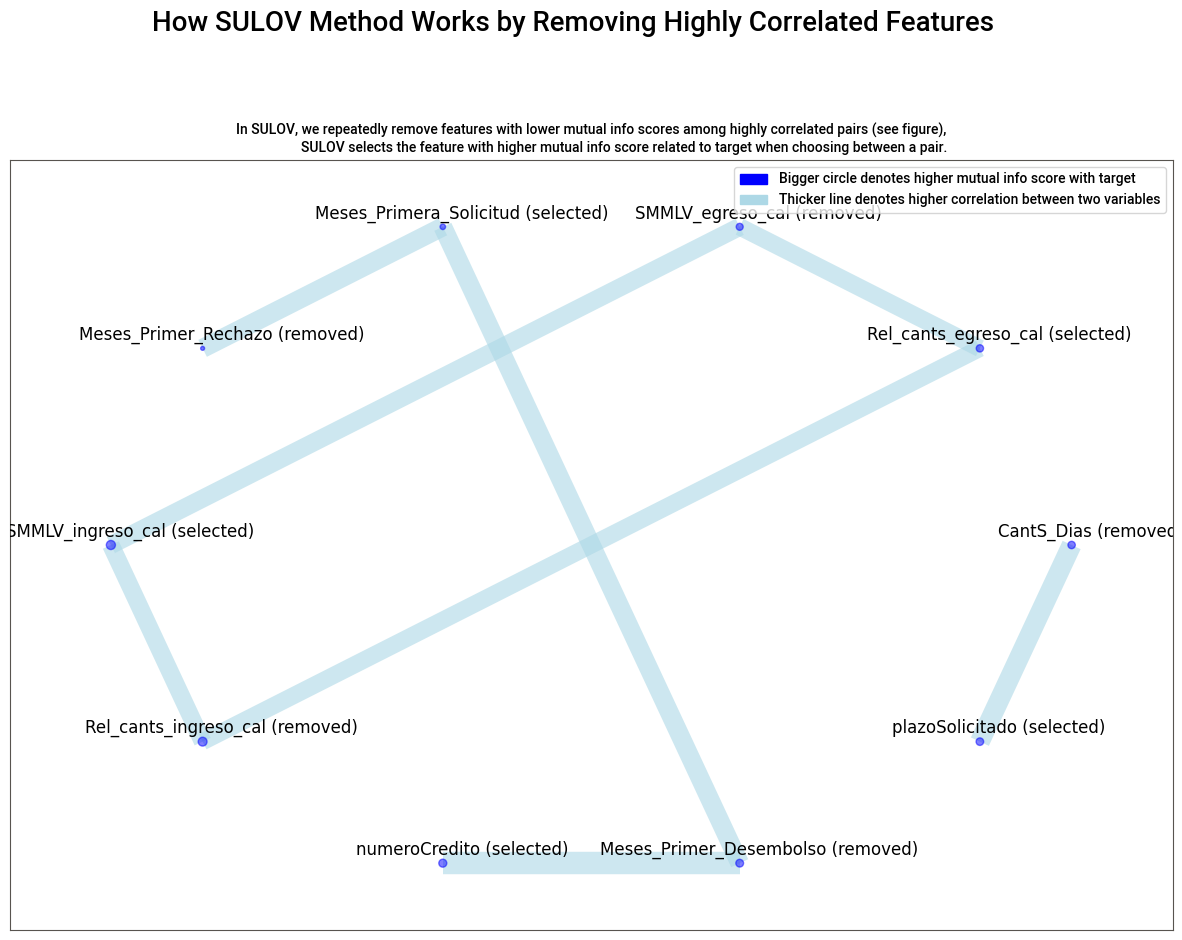

    Adding 8 categorical variables to reduced numeric variables  of 14
############## F E A T U R E   S E L E C T I O N  ####################
Current number of predictors = 22 
    Finding Important Features using Boosted Trees algorithm...
        using 22 variables...
        using 18 variables...
        using 14 variables...
        using 10 variables...
        using 6 variables...
        using 2 variables...
Selected 19 important features from your dataset
    Time taken (in seconds) = 15
Returning list of 19 important features and dataframe.


In [14]:
out1, out2 = featurewiz(base_muestra[campos], 'Target', corr_limit=0.6, verbose=2)

In [15]:
print(out1)

['plazoSolicitado', 'estadomovil', 'numeroCredito', 'estadoMovil_catg', 'numeroHijos', 'SMMLV_ingreso_cal', 'puntajeDS', 'Rel_cants_egreso_cal', 'nivelEstudio_catg', 'Sexo_catg', 'tipoTrabajador_catg', 'actividadLaboral', 'cantidadsolicitada', 'Meses_Primera_Solicitud', 'Ciudad_catg', 'Edad_cal', 'actividadLaboral_catg', 'estadocivil_catg', 'tipoVivienda_catg']


In [79]:
base_modelo = df_union_all.copy()

In [5]:
df_bivariado = analisis.bivariado(base_modelo, campos[:-1], 'Target')

In [6]:
df_bivariado.groupby('Variable', as_index=False).agg(IV=('Total IV','max')).sort_values(by='IV', ascending=False).head(20)

Variable        IV
10        SMMLV_ingreso_cal  0.402431
8     Rel_cants_ingreso_cal  0.340858
20            numeroCredito  0.317855
18              estadomovil  0.304498
16         estadoMovil_catg  0.304110
7      Rel_cants_egreso_cal  0.273032
19        nivelEstudio_catg  0.269073
9          SMMLV_egreso_cal  0.254179
3   Meses_Primer_Desembolso  0.251108
11                Score_cal  0.247416
23          plazoSolicitado  0.219762
5   Meses_Primera_Solicitud  0.155114
13         actividadLaboral  0.152767
0                CantS_Dias  0.142850
15       cantidadsolicitada  0.097214
4      Meses_Primer_Rechazo  0.092054
2                  Edad_cal  0.077741
6           Porcn_gasto_cal  0.074142
14    actividadLaboral_catg  0.062259
24                puntajeDS  0.056751

In [15]:
var_sel = ['SMMLV_ingreso_cal','numeroCredito','estadomovil','Rel_cants_egreso_cal','nivelEstudio_catg','Meses_Primera_Solicitud','plazoSolicitado'
          ,'actividadLaboral','cantidadsolicitada','Edad_cal','puntajeDS','numeroHijos','Ciudad_catg','Target']

In [8]:
len(var_sel)

13

In [12]:
df_bivariado.query(" Variable=='Ciudad_catg' ").sort_values(by='Bad Rate', ascending=False)

Variable         Value   All  Good  Bad     Share  Bad Rate  \
33  Ciudad_catg          OTRO  4286  3465  821  0.260183  0.191554   
32  Ciudad_catg     ATLANTICO   651   532  119  0.039519  0.182796   
31  Ciudad_catg     ANTIOQUIA   553   455   98  0.033570  0.177215   
30  Ciudad_catg          CALI   912   760  152  0.055363  0.166667   
29  Ciudad_catg  CUNDINAMARCA   693   585  108  0.042069  0.155844   
28  Ciudad_catg      MEDELLIN  2133  1836  297  0.129485  0.139241   
27  Ciudad_catg        BOGOTA  7245  6369  876  0.439811  0.120911   

    Distribution Good  Distribution Bad       WoE        IV  Total IV  
33           0.247465          0.332254 -0.294632  0.024982  0.055775  
32           0.037995          0.048159 -0.237057  0.002409  0.055775  
31           0.032495          0.039660 -0.199247  0.001428  0.055775  
30           0.054278          0.061514 -0.125139  0.000905  0.055775  
29           0.041780          0.043707 -0.045097  0.000087  0.055775  
28           0.131124          0.120194  0.087035  0.000951  0.055775  
27           0.454864          0.354512  0.249254  0.025013  0.055775

In [30]:
base_modelo['nivelEstudio_catg'] = np.where(base_modelo['nivelEstudio_catg']=='Basico', 1
                                           ,(np.where(base_modelo['nivelEstudio_catg']=='Bachiller', 2
                                           ,np.where(base_modelo['nivelEstudio_catg']=='Ninguno', 3
                                           ,np.where(base_modelo['nivelEstudio_catg']=='Tecnico', 4
                                           ,np.where(base_modelo['nivelEstudio_catg']=='Tecnologo', 5
                                           ,np.where(base_modelo['nivelEstudio_catg']=='Pregrado', 6
                                           ,np.where(base_modelo['nivelEstudio_catg']=='Posgrado', 7 , 0))))))))

In [31]:
base_modelo['Ciudad_catg'] = np.where(base_modelo['Ciudad_catg']=='OTRO', 1
                                     ,(np.where(base_modelo['Ciudad_catg']=='ATLANTICO', 2
                                     ,np.where(base_modelo['Ciudad_catg']=='ANTIOQUIA', 3
                                     ,np.where(base_modelo['Ciudad_catg']=='CALI', 4
                                     ,np.where(base_modelo['Ciudad_catg']=='CUNDINAMARCA', 5
                                     ,np.where(base_modelo['Ciudad_catg']=='MEDELLIN', 6
                                     ,np.where(base_modelo['Ciudad_catg']=='BOGOTA', 7 , 0))))))))

### **Analisis con Arboles para identificar Relaciones en Comportamiento**

In [81]:
from sklearn.tree import DecisionTreeClassifier,plot_tree,export_text
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import (balanced_accuracy_score,average_precision_score, precision_recall_curve, roc_curve
                             , auc, recall_score, precision_score, confusion_matrix,classification_report)
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [82]:
base_modelo.shape

(39717, 43)

In [86]:
var_sel2 = ['SMMLV_ingreso_cal','numeroCredito','plazoSolicitado','Rel_cants_egreso_cal']

In [90]:
help(plot_tree)

Help on function plot_tree in module sklearn.tree._export:

plot_tree(decision_tree, *, max_depth=None, feature_names=None, class_names=None, label='all', filled=False, impurity=True, node_ids=False, proportion=False, rotate='deprecated', rounded=False, precision=3, ax=None, fontsize=None)
    Plot a decision tree.
    
    The sample counts that are shown are weighted with any sample_weights that
    might be present.
    
    The visualization is fit automatically to the size of the axis.
    Use the ``figsize`` or ``dpi`` arguments of ``plt.figure``  to control
    the size of the rendering.
    
    Read more in the :ref:`User Guide <tree>`.
    
    .. versionadded:: 0.21
    
    Parameters
    ----------
    decision_tree : decision tree regressor or classifier
        The decision tree to be plotted.
    
    max_depth : int, optional (default=None)
        The maximum depth of the representation. If None, the tree is fully
        generated.
    
    feature_names : list of st

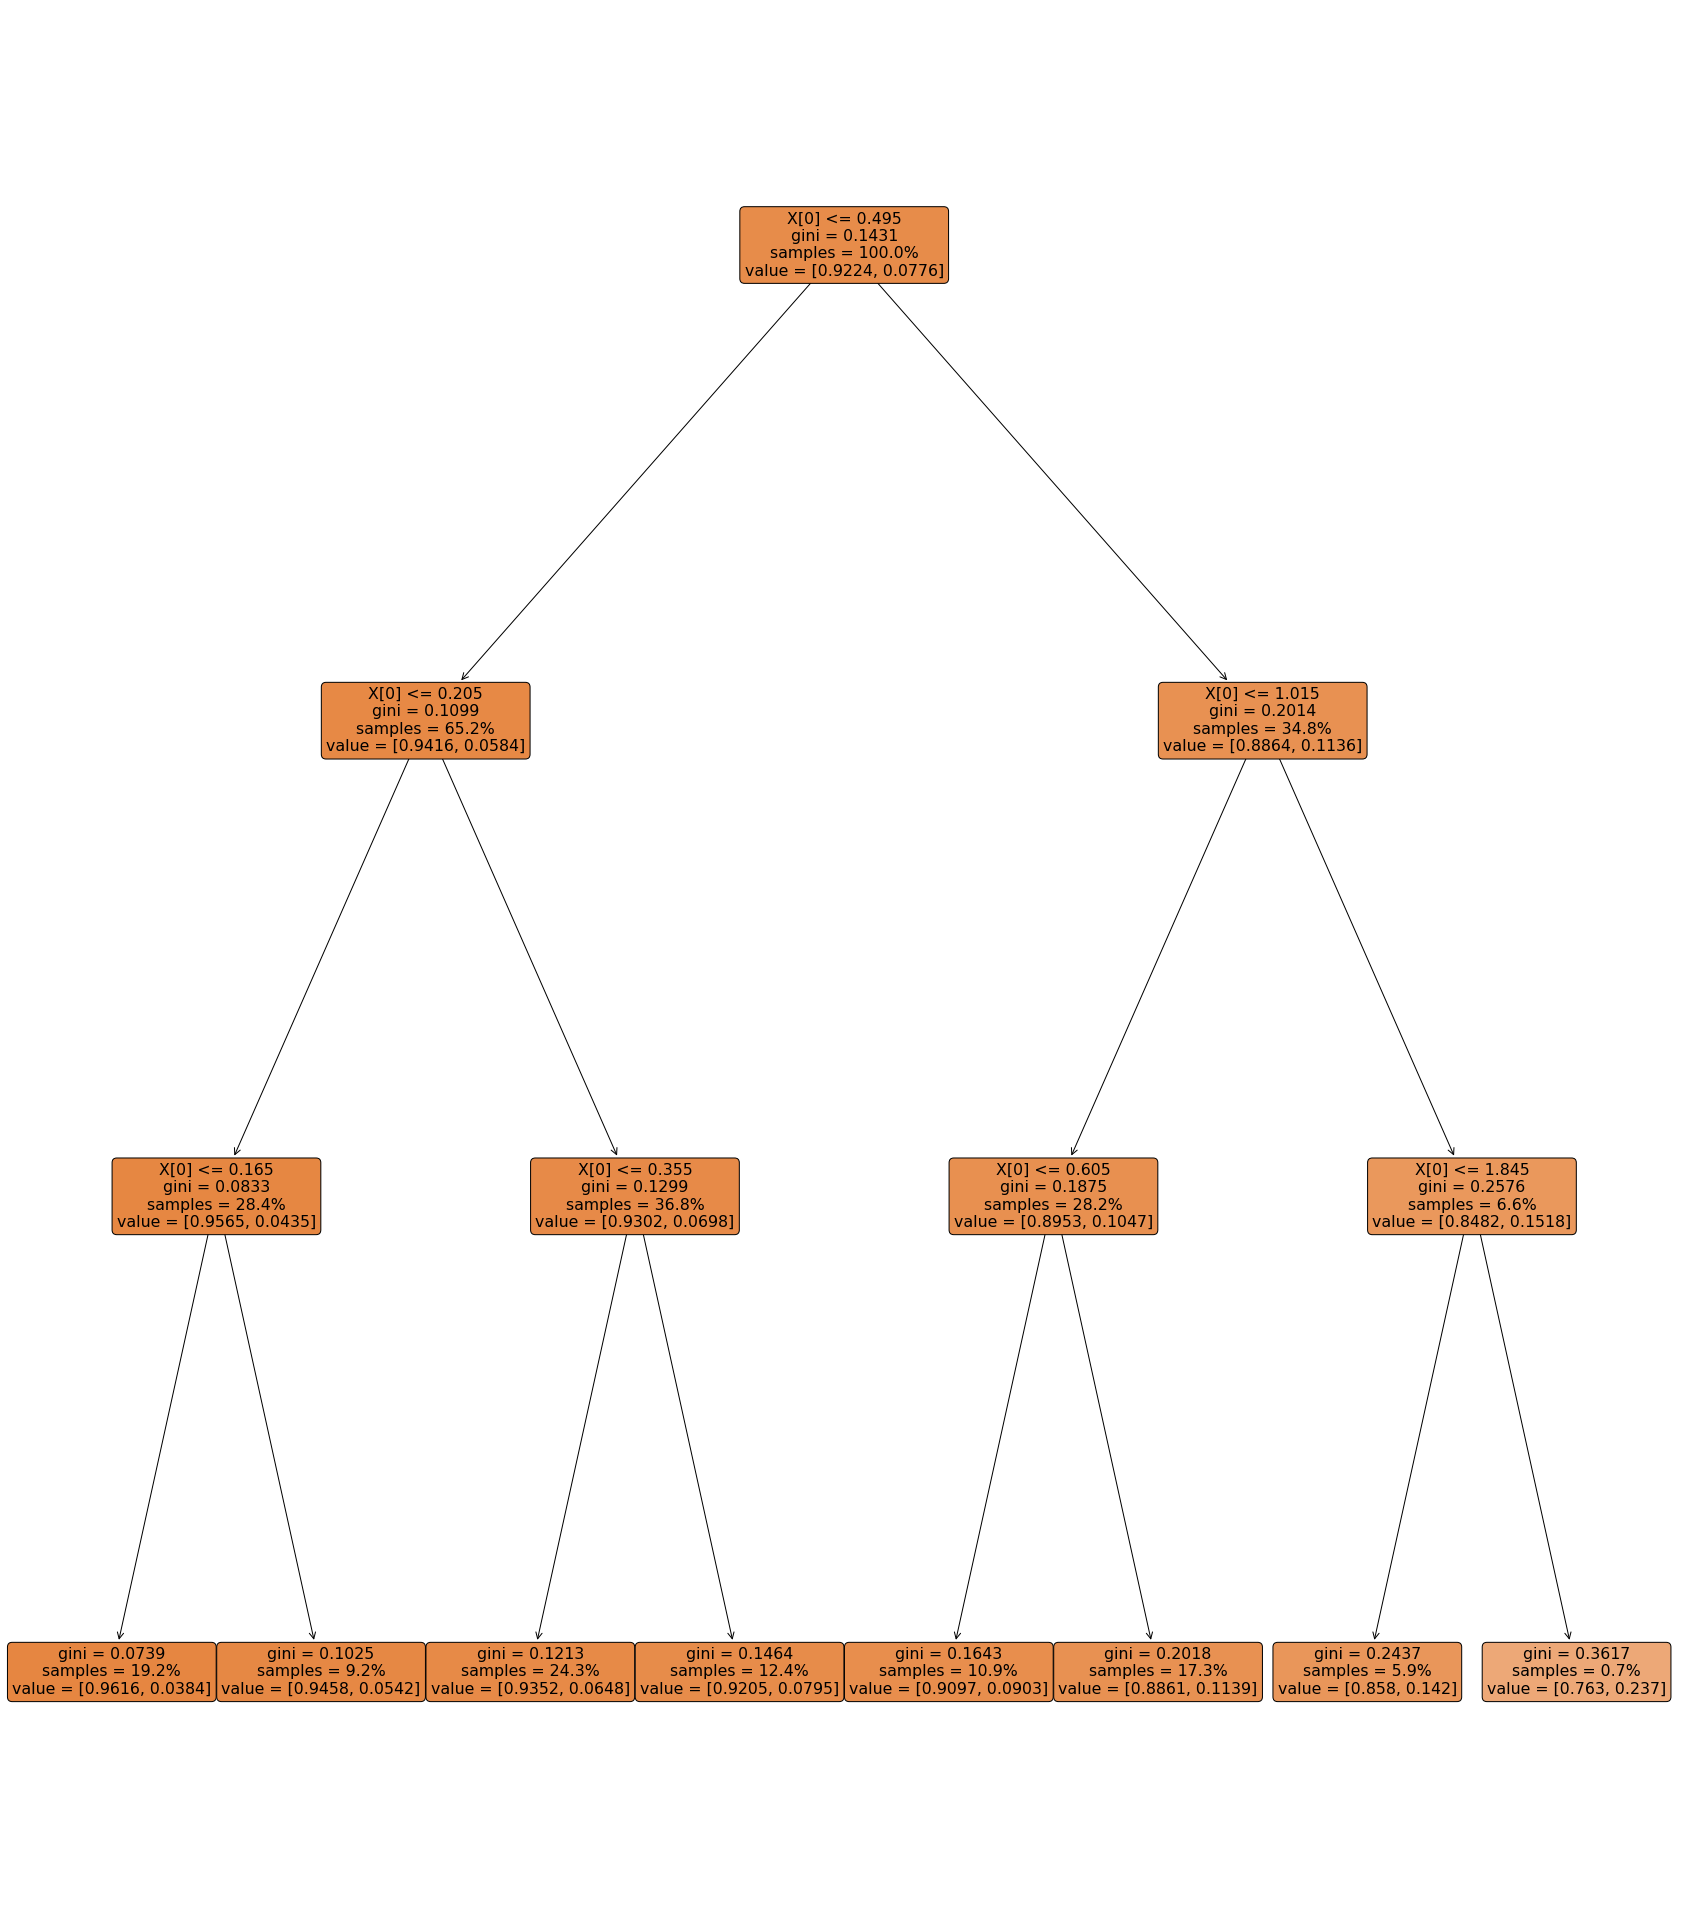

In [91]:
arbol = DecisionTreeClassifier(max_depth=3)
lista = []
plt.figure(figsize = (30,35))
for i in var_sel2:
    arbol.fit(base_modelo[[i]],base_modelo[['Target']])
    plot_tree(arbol, filled = True , precision = 4, rounded = True, proportion=True)
    lista.append(export_text(arbol,feature_names=[i]))
    plt.savefig(fname=i + '_2')

In [85]:
X_train, X_test, y_train, y_test = modelado.particion(base_modelo[var_sel2],'Target',0.25)

In [112]:
clf = DecisionTreeClassifier()

In [113]:
grid = {'max_depth': [3,4,5]}

In [114]:
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [115]:
clf_cv = GridSearchCV(estimator = clf, param_grid = grid, scoring='roc_auc', cv = 4, verbose=2, n_jobs = -1)

In [116]:
clf_cv.fit(X_train, y_train)

Fitting 4 folds for each of 3 candidates, totalling 12 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5]}, scoring='roc_auc', verbose=2)

In [117]:
clf_cv.best_params_

{'max_depth': 5}

In [118]:
pd.Series(clf_cv.best_estimator_.feature_importances_, index=base_modelo[var_sel2[:-1]].columns).sort_values(ascending=False)

SMMLV_ingreso_cal       0.432292
numeroCredito           0.322931
plazoSolicitado         0.189962
Rel_cants_egreso_cal    0.054815
dtype: float64

In [119]:
accuracies, media_cross, desviacion_cross = modelado.validacion_cruzada(clf_cv.best_estimator_, X_train, y_train, 4, 'roc_auc')

In [120]:
print(accuracies, media_cross, desviacion_cross)

[0.70642799 0.71578202 0.71366944 0.69209462] 0.7069935197031396 0.009275002604163887


In [121]:
f, ax = plt.subplots(figsize=(95, 85))
plot_tree(clf_cv.best_estimator_,proportion=True, precision = 4, filled=True, ax=ax, fontsize=6, feature_names=base_modelo[var_sel2[:-1]].columns)
plt.savefig(fname='arbol_prueba6')

In [69]:
train_pred1, test_pred1 = modelado.calificacion('si', clf_cv.best_estimator_, X_train, X_test, y_train, y_test)

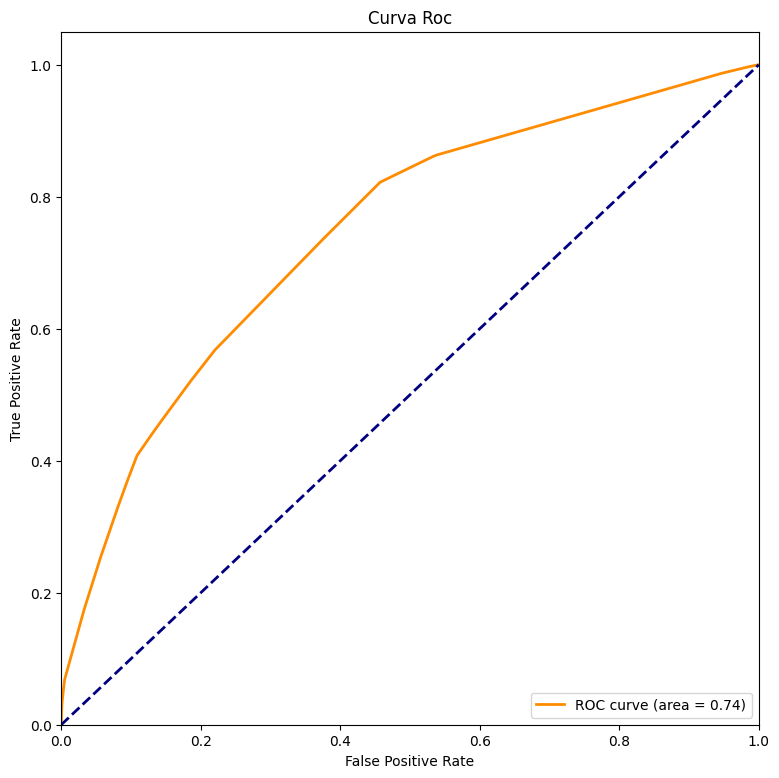


*************************************************************

El coeficiente de GINI es: 0.49

El área por debajo de la curva ROC es: 0.74

*************************************************************


0

In [73]:
modelado.plot_roc_gini(train_pred1.Target, train_pred1.probabilidad)

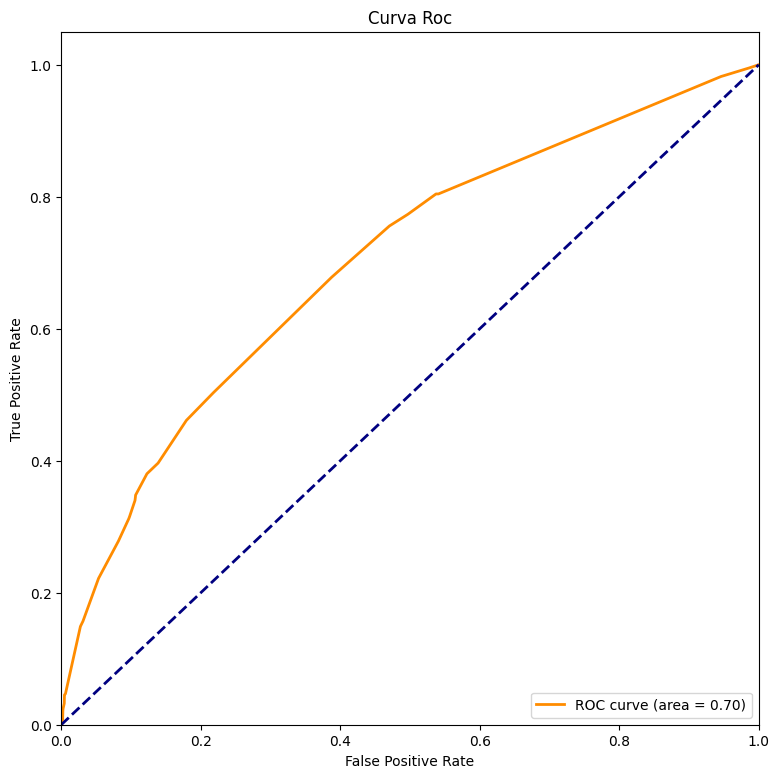


*************************************************************

El coeficiente de GINI es: 0.40

El área por debajo de la curva ROC es: 0.70

*************************************************************


0

In [74]:
modelado.plot_roc_gini(test_pred1.Target, test_pred1.probabilidad)

In [20]:
clf_i = DecisionTreeClassifier(max_depth=3)

In [123]:
var_sel2

['SMMLV_ingreso_cal',
 'numeroCredito',
 'plazoSolicitado',
 'Rel_cants_egreso_cal',
 'Target']

In [21]:
clf_i.fit(base_muestra[['Rel_cants_egreso_cal']], base_muestra['Target'])

DecisionTreeClassifier(max_depth=3)

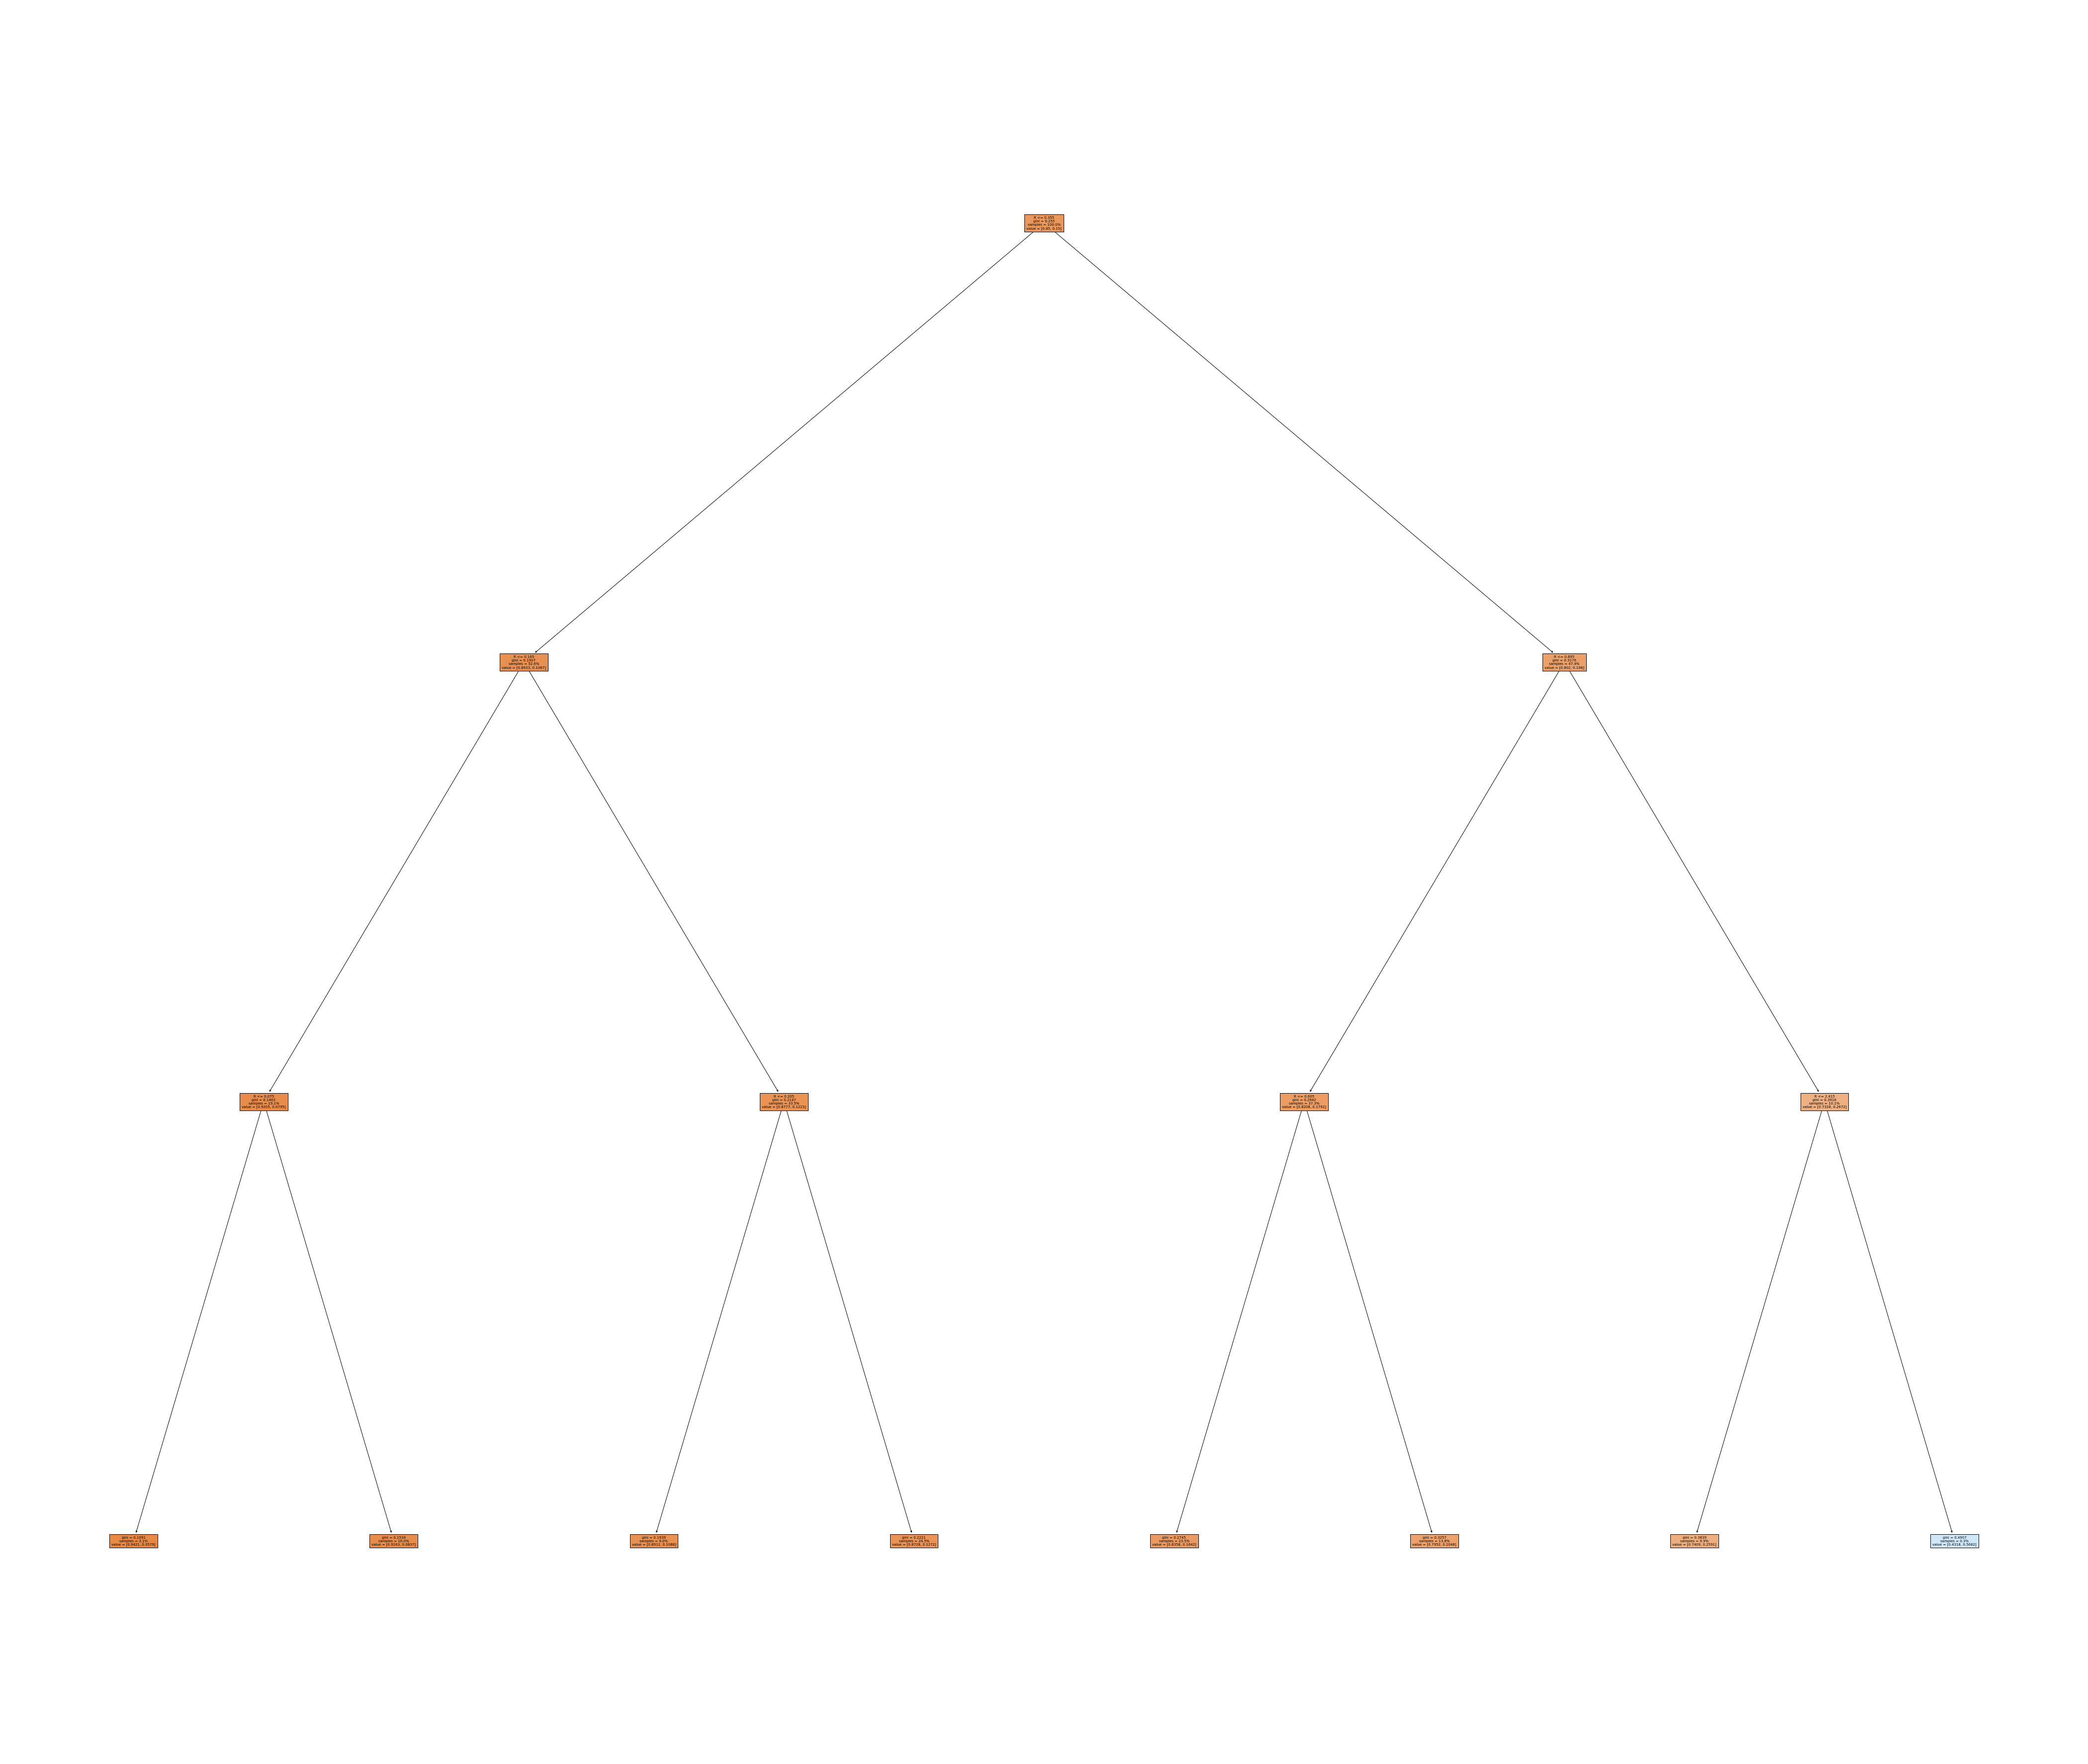

In [23]:
f, ax = plt.subplots(figsize=(75, 65))
plot_tree(clf_i,proportion=True, precision = 4, filled=True, ax=ax, fontsize=7, feature_names='Rel_cants_egreso_cal')
plt.savefig(fname='Rel_cants_egreso_cal')

In [35]:
base_modelo['SMMLV_ingreso_cal'] = np.where(base_modelo['SMMLV_ingreso_cal']<=1.45, 1
                                           ,(np.where((base_modelo['SMMLV_ingreso_cal']>1.45) & (base_modelo['SMMLV_ingreso_cal']<=2.44), 2
                                           ,np.where((base_modelo['SMMLV_ingreso_cal']>2.44) & (base_modelo['SMMLV_ingreso_cal']<=2.77), 3
                                           ,np.where((base_modelo['SMMLV_ingreso_cal']>2.77) & (base_modelo['SMMLV_ingreso_cal']<=3.65), 4
                                           ,np.where((base_modelo['SMMLV_ingreso_cal']>3.65) & (base_modelo['SMMLV_ingreso_cal']<=4.47), 5
                                           ,np.where(base_modelo['SMMLV_ingreso_cal']>4.47, 6, 0)))))))

In [36]:
base_modelo['numeroCredito'] = np.where(base_modelo['numeroCredito']<=5, 1
                                       ,(np.where((base_modelo['numeroCredito']>5) & (base_modelo['numeroCredito']<=7), 2
                                       ,np.where((base_modelo['numeroCredito']>7) & (base_modelo['numeroCredito']<=13), 3
                                       ,np.where((base_modelo['numeroCredito']>13) & (base_modelo['numeroCredito']<=27), 4
                                       ,np.where(base_modelo['numeroCredito']>27, 5, 0))))))

In [37]:
base_modelo['Rel_cants_egreso_cal'] = np.where(base_modelo['Rel_cants_egreso_cal']>0.89, 1
                                              ,(np.where((base_modelo['Rel_cants_egreso_cal']>0.6) & (base_modelo['Rel_cants_egreso_cal']<=0.89), 2
                                              ,np.where((base_modelo['Rel_cants_egreso_cal']>0.35) & (base_modelo['Rel_cants_egreso_cal']<=0.6), 3
                                              ,np.where((base_modelo['Rel_cants_egreso_cal']>0.16) & (base_modelo['Rel_cants_egreso_cal']<=0.35), 4
                                              ,np.where(base_modelo['Rel_cants_egreso_cal']<=0.16, 5, 0))))))

In [38]:
print(var_sel2)

['SMMLV_ingreso_cal', 'numeroCredito', 'plazoSolicitado', 'Rel_cants_egreso_cal', 'Target']


In [42]:
X_train, X_test, y_train, y_test = modelado.particion(base_modelo[var_sel2],'Target',0.25)

In [50]:
clf_2 = DecisionTreeClassifier()

In [51]:
grid = {'max_depth': [3,4,5]}

In [52]:
clf_2.fit(X_train, y_train)

DecisionTreeClassifier()

In [53]:
clf_2cv = GridSearchCV(estimator = clf_2, param_grid = grid, scoring='roc_auc', cv = 4, verbose=2, n_jobs = -1)

In [54]:
clf_2cv.fit(X_train, y_train)

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5]}, scoring='roc_auc', verbose=2)

In [55]:
accuracies, media_cross, desviacion_cross = modelado.validacion_cruzada(clf_2cv.best_estimator_, X_train, y_train, 4, 'roc_auc')

In [56]:
print(accuracies, media_cross, desviacion_cross)

[0.72058325 0.71138177 0.70710439 0.71321814] 0.7130718899103426 0.004871074837202


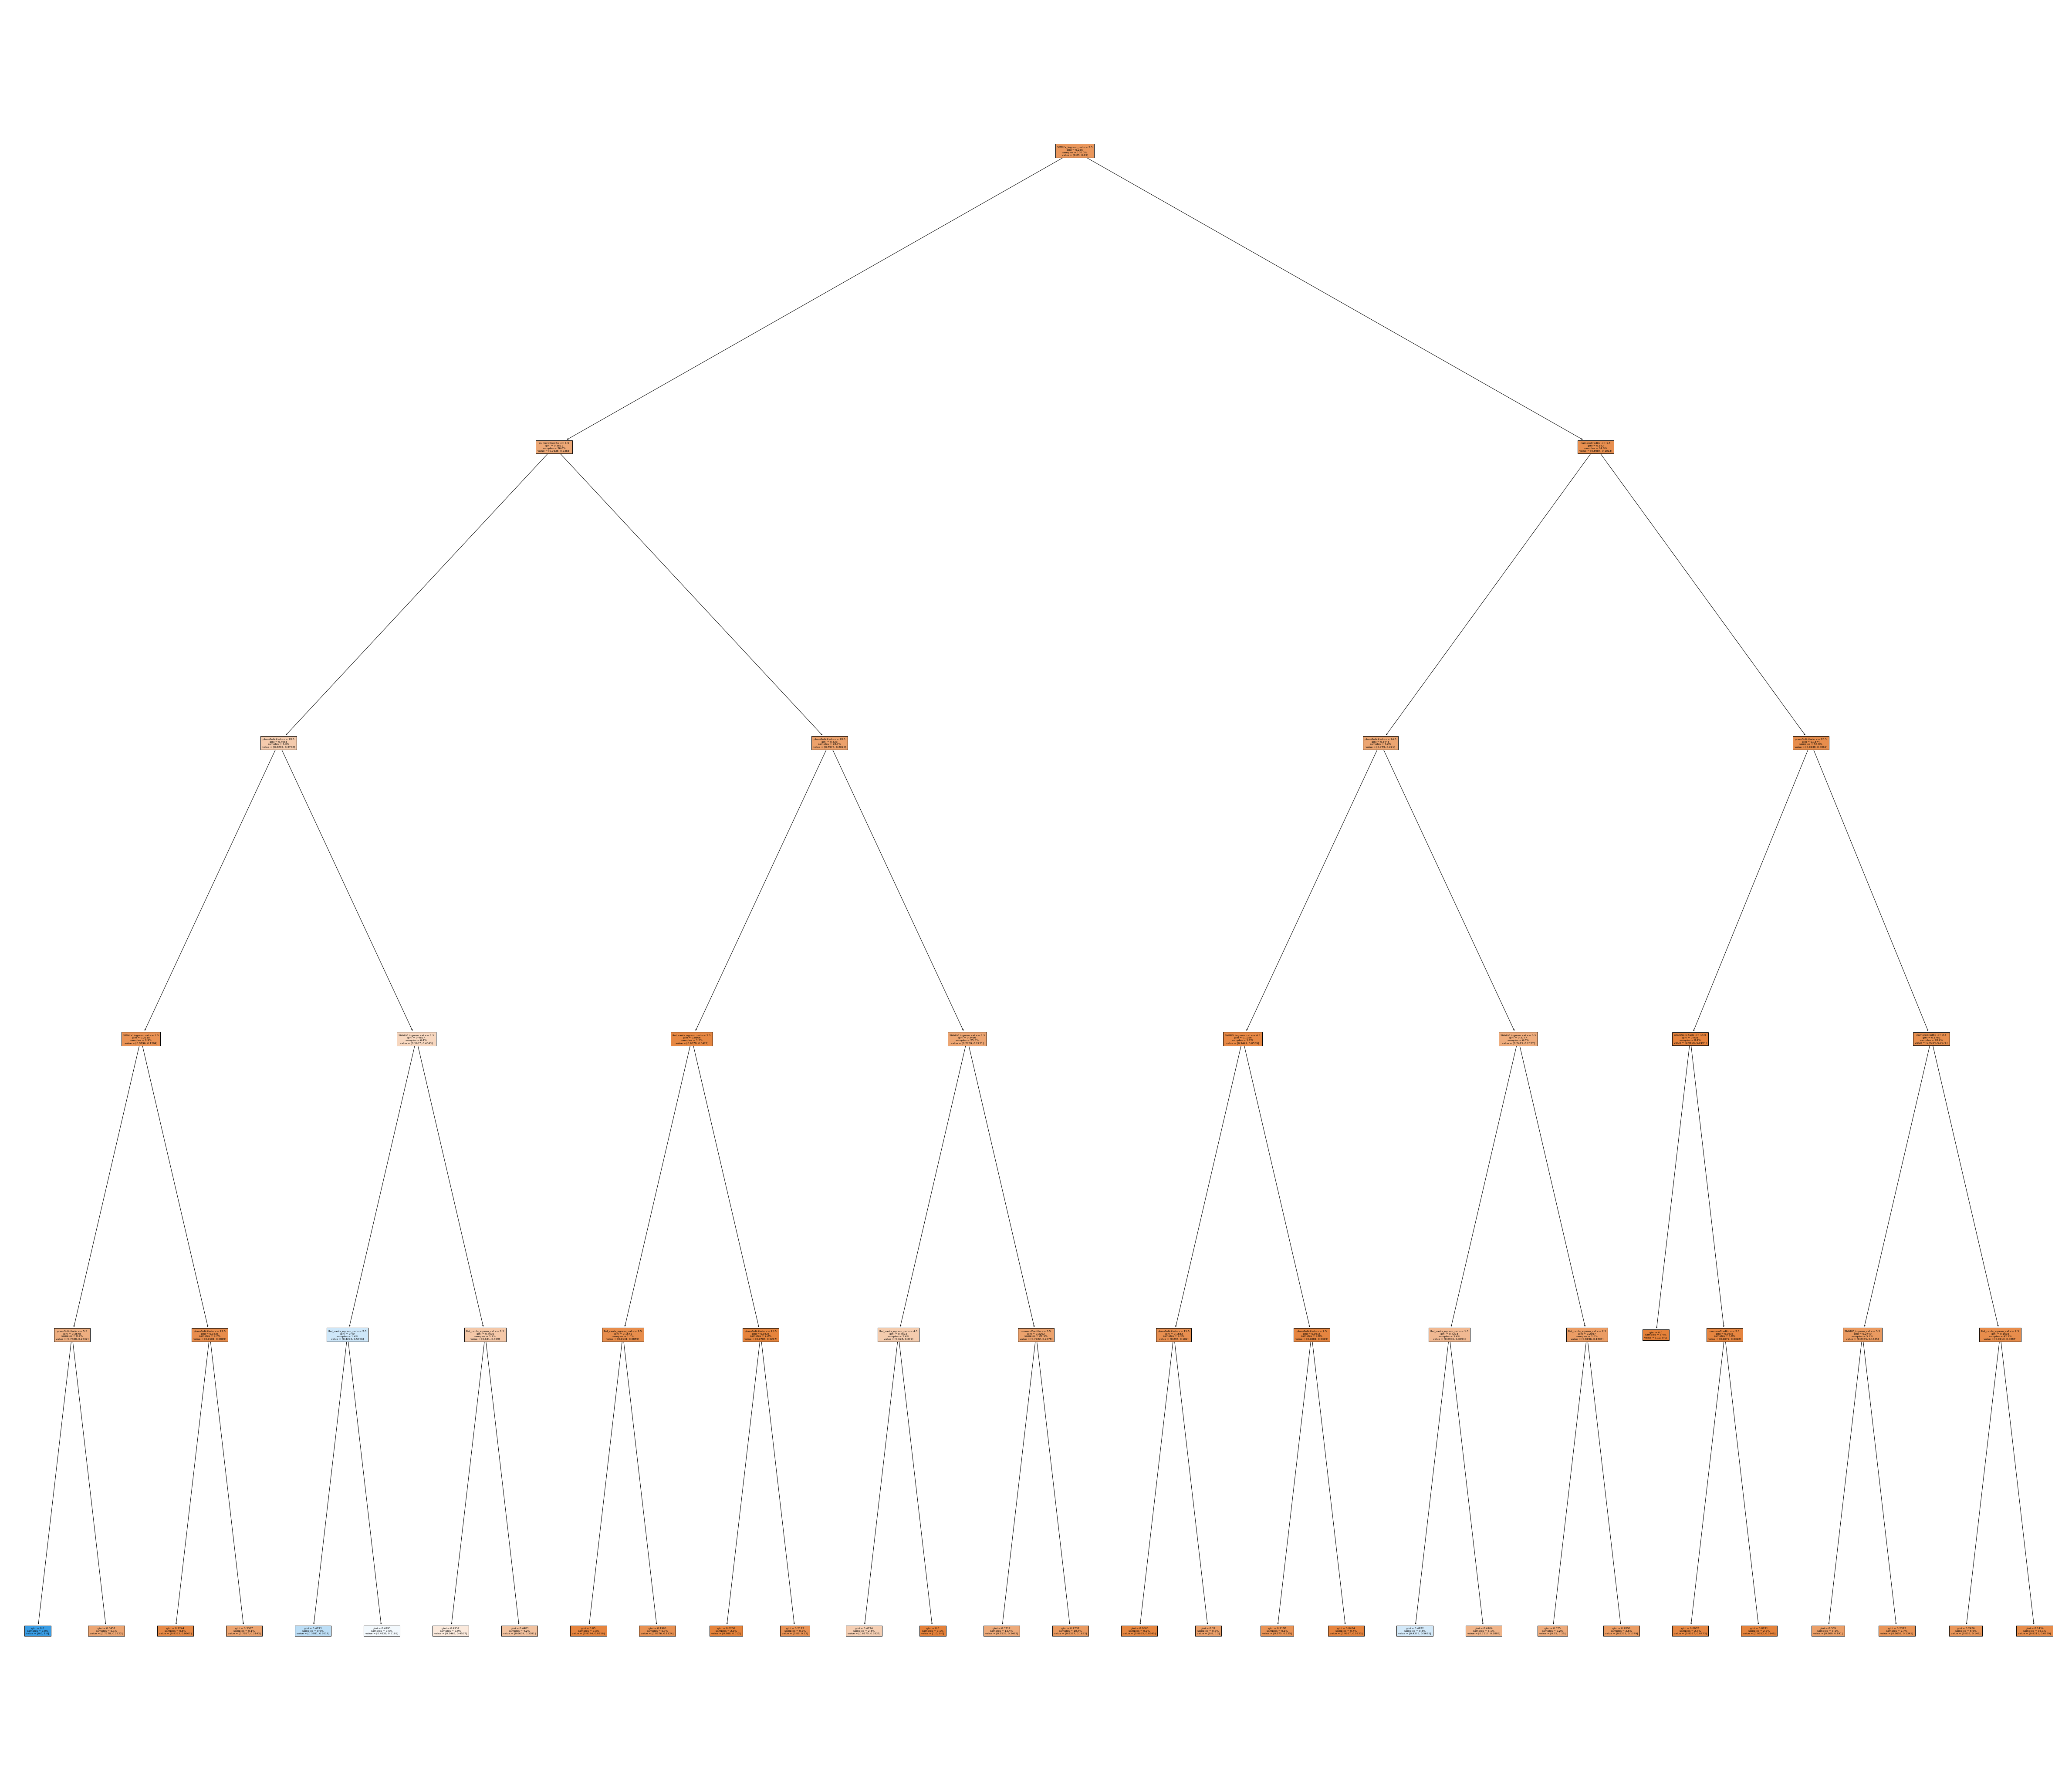

In [57]:
f, ax = plt.subplots(figsize=(85, 75))
plot_tree(clf_2cv.best_estimator_,proportion=True, precision = 4, filled=True, ax=ax, fontsize=6, feature_names=base_modelo[var_sel2[:-1]].columns)
plt.savefig(fname='arbol_prueba8')

In [59]:
base_modelo.groupby('Tipo_Cliente')[['numeroCredito']].describe()

numeroCredito                                             
                     count      mean       std  min  25%  50%  75%  max
Tipo_Cliente                                                           
Nuevo                104.0  1.067308  0.251767  1.0  1.0  1.0  1.0  2.0
Recurrente         16369.0  3.145702  1.184720  1.0  2.0  3.0  4.0  5.0